In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import drive # Library to mount google drives
from tqdm.notebook import tqdm
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Specify the base directory where images are located.
base_dir = '/content/gdrive/My Drive/'

In [ ]:
## The location of the Flickr8K_ images
dir_Flickr_jpg = os.path.join(base_dir,'Images')
## The location of the caption file
dir_Flickr_text = os.path.join(base_dir,'/content/captions.txt')

### Extracting image features

Feature extraction is a part of the dimensionality reduction process, in which, an initial set of the raw data is divided and reduced to more manageable groups. So Feature extraction helps to get the best feature from those big data sets by selecting and combining variables into features.
Here, we need to convert the image into an encoding so that the machine can understand the patterns in it so we are using transfer learning i.e, we use a pre-trained model VGG16 which has been already trained on large datasets and extract the features from these models and use them for our work.

In [ ]:
# Load vgg16 Model
model = VGG16()

# restructure model
# Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

### extract the image features

In [ ]:
# extract features from image
features = {}
directory = os.path.join(base_dir, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8112 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
# Extracted features are not stored in the disk, so re-extraction of features can extend running time
pickle.dump(features, open(os.path.join(base_dir, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(base_dir, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

#### Loading captions data
Let us store the captions data from the text file

In [ ]:
with open(os.path.join(base_dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

#### Preprocessing Text Data

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

#### Let us visualize the text before and after cleaning

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
#Let us see the first ten captions
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

#### 'startseq' and 'endseq' tags is added to indicate the start and end of a caption for easier processing.

### Now we start processing the text data

In [ ]:
# tokenize the text
# Machines are not familiar with complex English words so, to process model’sdata they need a simple numerical representation.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
# No. of unique words
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### This is the maximum length of the captions, used for reference for the padding sequence.

### we are going to use an embedding matrix to store the relations between words in our vocabulary. An embedding matrix is a linear mapping of the original space to a real-valued space where entities will have meaningful relationships.

### Now we will define a batch and include the padding sequence, Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.

In [ ]:
# create data generator to get data in batch.
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

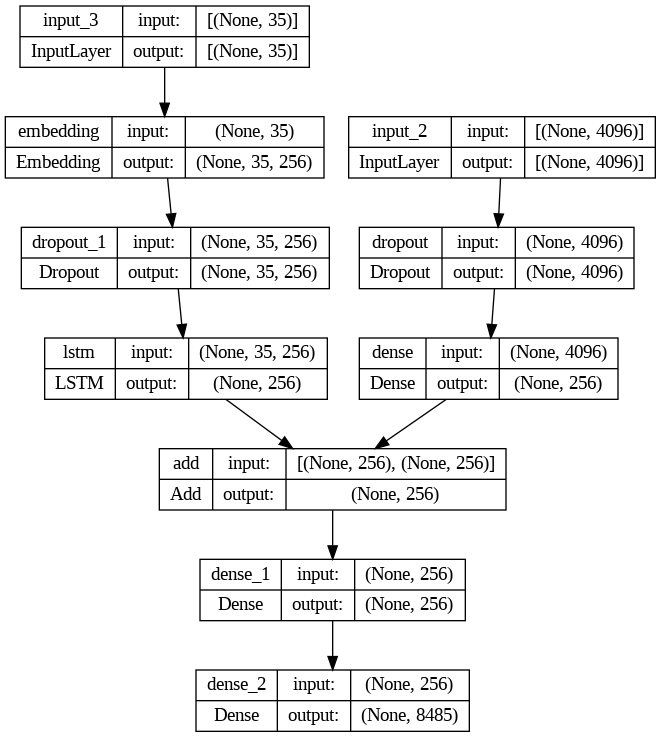

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

This code defines an encoder-decoder model that takes image features and a sequence of text as inputs, processes them through multiple layers, and generates a probability distribution over a vocabulary of words as the output. The model is then compiled with a loss function and an optimizer for training.

### Now let us train the model

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

Here we split a list of image IDs into a training set (train) and a test set (test) using a 90/10 split ratio. The image_ids list is created from the keys of a dictionary called mapping, and the split is determined by calculating 90% of the length of the image_ids list. The resulting training set (train) contains the first 90% of the image IDs, while the test set (test) contains the remaining 10% of the image IDs.

208/208 [==============================] - 38s 184ms/step - loss: 2.0759


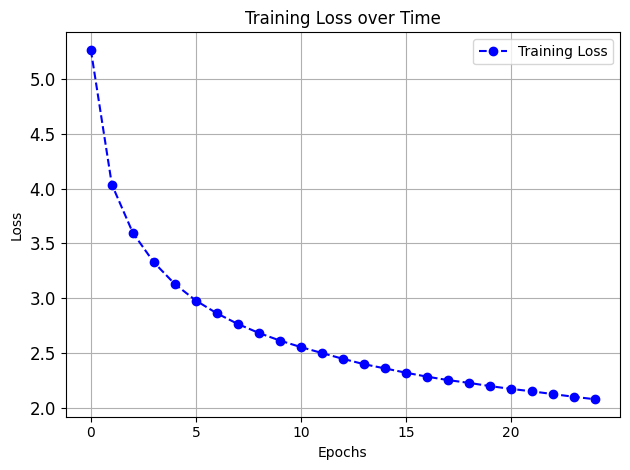

In [ ]:
# train the model
epochs = 25
batch_size = 35
steps = len(train) // batch_size
loss_values = []

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    history=model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss_values.append(history.history['loss'])
# plot the loss values over time
plt.plot(loss_values, linestyle='--', marker='o', color='blue', label='Training Loss')
plt.title('Training Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, epochs, 5))
plt.yticks(fontsize=12)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Generating Captions for the Image
### First we are going to Convert the predicted index from the model into a word


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:

# generating caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

Now we are going to validate the data using BLEU Score. BLEU (BiLingual Evaluation Understudy) is a metric for automatically evaluating machine-translated text and the BLEU score is a number between zero and one that measures the similarity of the machine-translated text to a set of high quality reference translations.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.545455
BLEU-2: 0.233550
BLEU-1: 0.478261
BLEU-2: 0.261387
BLEU-1: 0.375000
BLEU-2: 0.204124
BLEU-1: 0.360656
BLEU-2: 0.177866
BLEU-1: 0.351351
BLEU-2: 0.159563
BLEU-1: 0.365854
BLEU-2: 0.155143
BLEU-1: 0.389474
BLEU-2: 0.199581
BLEU-1: 0.403846
BLEU-2: 0.224679
BLEU-1: 0.421053
BLEU-2: 0.236940
BLEU-1: 0.450820
BLEU-2: 0.261587
BLEU-1: 0.476923
BLEU-2: 0.290108
BLEU-1: 0.496454
BLEU-2: 0.297515
BLEU-1: 0.487013
BLEU-2: 0.281854
BLEU-1: 0.475904
BLEU-2: 0.268350
BLEU-1: 0.466667
BLEU-2: 0.260536
BLEU-1: 0.461538
BLEU-2: 0.258919
BLEU-1: 0.485437
BLEU-2: 0.282174
BLEU-1: 0.484163
BLEU-2: 0.288923
BLEU-1: 0.483051
BLEU-2: 0.290843
BLEU-1: 0.491870
BLEU-2: 0.291342
BLEU-1: 0.484733
BLEU-2: 0.283643
BLEU-1: 0.489051
BLEU-2: 0.285497
BLEU-1: 0.494700
BLEU-2: 0.295844
BLEU-1: 0.498282
BLEU-2: 0.296163
BLEU-1: 0.506711
BLEU-2: 0.304638
BLEU-1: 0.509804
BLEU-2: 0.307698
BLEU-1: 0.506369
BLEU-2: 0.302897
BLEU-1: 0.498480
BLEU-2: 0.301802
BLEU-1: 0.502976
BLEU-2: 0.302899
BLEU-1: 0.5099

## Visualize the Results

In [ ]:
from PIL import Image
def generate_caption(image_name):
    # load the image
    # image_name = "3637013_c675de7705.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq couple stands close at the water 's edge endseq
startseq the two people stand by body of water and in front of bushes in fall endseq
startseq two people hold each other near pond endseq
startseq two people stand by the water endseq
startseq two people stand together on the edge of the water on the grass endseq
--------------------Predicted--------------------
startseq two people stand in front of body of water endseq


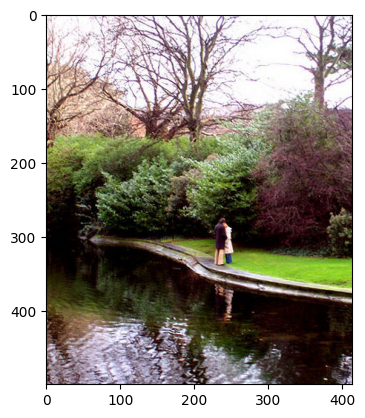

In [ ]:
generate_caption("3637013_c675de7705.jpg")

---------------------Actual---------------------
startseq man at the top of mountain with beautiful view in the background endseq
startseq man is sitting on snowbank endseq
startseq man on snowy peak endseq
startseq person in red snow gear is kneeling on snowy ridge under blue sky endseq
startseq mountain climber in red suit poses on snowy peak with mountains in the background endseq
--------------------Predicted--------------------
startseq man wearing red coat is hiking up snowy mountain endseq


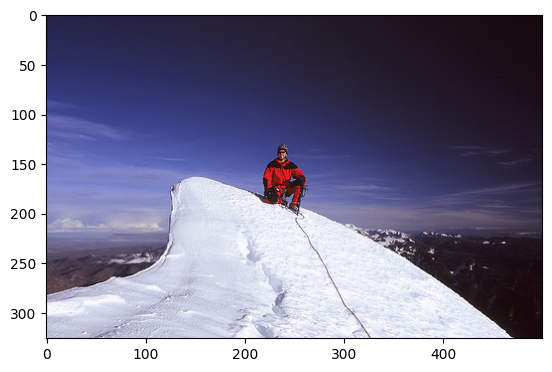

In [ ]:
generate_caption("55473406_1d2271c1f2.jpg")

---------------------Actual---------------------
startseq dog is jumping over log in wooded area while carrying another log endseq
startseq dog with stick in his mouth jumps over fallen tree in the forest endseq
startseq dog carries stick and jumps over log endseq
startseq the dog carries stick and jumps over log in the woods endseq
startseq the dog jumps over the log with stick in its mouth endseq
--------------------Predicted--------------------
startseq dog carries log in the grass endseq


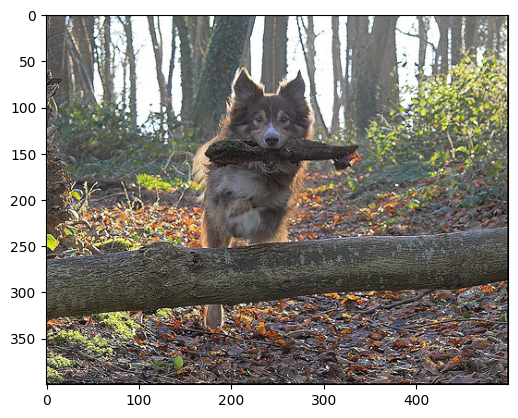

In [ ]:
generate_caption("378453580_21d688748e.jpg")

## Test with Real Image

In [ ]:
vgg_model = VGG16() 
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,             
                  outputs=vgg_model.layers[-2].output)

In [ ]:
image_path = '/content/gdrive/My Drive/Images/111766423_4522d36e56.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

"startseq black and white bird is clinging to someone about to someone 's hand endseq"